#GX33-4 Optical Reduction
This IPython Notebook shows a typtical work flow for reducing a bunch of optical data for a particular target-in this case GX339. Ideally this will all be generalized so it can be used on any target pretty easily

In [13]:
#import some things
import glob, sys, os
import numpy as np 
from pyraf import iraf
from astropy.io import ascii
import pandas as pd
#append the python path so it can use alipy and stuff
sys.path.append('/home/ih64/python_modules/')
import alipy
#do this stuff down here so IRAF doesn't save any parameters, and to make important tasks avaliable 
iraf.prcacheOff()
iraf.imred()
iraf.ccdred()
import matplotlib.pyplot as plt
%matplotlib inline

##Align Images
The images in each band are not necessarily aligned together. We will use a python routine to align the B band images together, all the Vband images together, and all the I band images together. After this is done, each filter will have its own new images which are aligned and share a coordinate system. this will make aperture photometry very easy

In [ ]:
#this takes a long time to run bc there are many images. just be patient and let the program do its thing
#i would also recommend running this on one of the department's heavier duty computers, i.e. tortoise, turtle, etc
#the aligned images are output to a new directory for each filter. ie aligned Iband images go to fitsimages/I_align

#this dictionary contains the reference image for each filter
refdict={"V":"rccd150620.0057.fits","I":"rccd150620.0058.fits"}

#loop over the different filters
for i in ["V","I"]:
    #get a listing of the path for each image for a given filter
    images_to_align = sorted(glob.glob("fitsimages/"+i+"/*.fits"))
    ref_image = "fitsimages/"+i+"/"+refdict[i]

    #everything below here i copied from the alipy demo http://obswww.unige.ch/~tewes/alipy/tutorial.html
    identifications = alipy.ident.run(ref_image, images_to_align, visu=False)
    # That's it !
    # Put visu=True to get visualizations in form of png files (nice but much slower)
    # On multi-extension data, you will want to specify the hdu (see API doc).

    # The output is a list of Identification objects, which contain the transforms :
    for id in identifications: # list of the same length as images_to_align.
            if id.ok == True: # i.e., if it worked

                    print "%20s : %20s, flux ratio %.2f" % (id.ukn.name, id.trans, id.medfluxratio)
                    # id.trans is a alipy.star.SimpleTransform object. Instead of printing it out as a string,
                    # you can directly access its parameters :
                    #print id.trans.v # the raw data, [r*cos(theta)  r*sin(theta)  r*shift_x  r*shift_y]
                    #print id.trans.matrixform()
                    #print id.trans.inverse() # this returns a new SimpleTransform object

            else:
                    print "%20s : no transformation found !" % (id.ukn.name)

    # Minimal example of how to align images :

    outputshape = alipy.align.shape(ref_image)
    # This is simply a tuple (width, height)... you could specify any other shape.

    for id in identifications:
            if id.ok == True:
                    # Variant 2, using geomap/gregister, correcting also for distortions :
                    alipy.align.irafalign(id.ukn.filepath, id.uknmatchstars, id.refmatchstars,verbose=False,
                                          shape=outputshape, makepng=False, outdir="fitsimages/"+i+"_align/")
    print "finished "+i

##Aperture Photometry with PyRAF
now we have many aligned images. we can make a coordinate list of the sources we are interested in for the reference image and use this coordinate list to do photometry on every image

open up the aligned reference image in imexame in IRAF w SAO Image DS9 with the following command at the IRAF prompt

    ecl> imexamine image keeplog+ logfile=michellecoords.lis

where image is the reference image. then the cursor will turn into a blinking disk. hover the blinking disk over A0620, and press the 'x' key. this will print the coordinates of the cursor to the logfile. do this for each reference image

In [19]:
#we now have many aligned images and a coordinate list, we are ready to do aperture photometry. 
#first we need to set the task parameters for all the IRAF tasks that work with the photometry task
#for reference check out what suzanne did here http://www.ctio.noao.edu/noao/content/13-m-smarts-photometric-calibrations-bvri
#setting pyraf parameters is somewhat confusing, for more details head here : http://www.stsci.edu/institute/software_hardware/pyraf/pyraf_faq#4.6

#centerpars
centerpars=iraf.centerpars.getParDict()
centerpars['calgorithm'].set('centroid')
centerpars['cbox'].set('10')
centerpars['cthreshold'].set('0')
centerpars['minsnratio'].set('1')
centerpars['cmaxiter'].set('10')
centerpars['maxshift'].set('5')
centerpars['clean'].set('no')
centerpars['rclean'].set('1')
centerpars['rclip'].set('2')
centerpars['kclean'].set('3')
centerpars['mkcenter'].set('yes')

#datapars
datapars=iraf.datapars.getParDict()
datapars['scale'].set('1')
datapars['fwhmpsf'].set('5')
datapars['emission'].set('yes')
datapars['sigma'].set('INDEF')
datapars['datamin'].set('-500')
datapars['datamax'].set('30000')
datapars['noise'].set('poisson')
datapars['readnoise'].set('6.5')
datapars['epadu'].set('2.3')
datapars['exposure'].set('EXPTIME')
datapars['airmass'].set('SECZ')
datapars['filter'].set('CCDFLTID')
datapars['obstime'].set('JD')

#findpars
findpars=iraf.findpars.getParDict()
findpars['threshold'].set('4.0')
findpars['nsigma'].set('1.5')
findpars['ratio'].set('1')
findpars['theta'].set('0')
findpars['sharplo'].set('0.2')
findpars['sharphi'].set('1.')
findpars['roundlo'].set('-1.')
findpars['roundhi'].set('1.')
findpars['mkdetections'].set('no')

#skypars
skypars=iraf.fitskypars.getParDict()
skypars['salgorithm'].set('mode')
skypars['annulus'].set('25.')
skypars['dannulus'].set('7.')
skypars['skyvalue'].set('0.')
skypars['smaxiter'].set('10')
skypars['sloclip'].set('0.')
skypars['shiclip'].set('0.')
skypars['snreject'].set('50')
skypars['sloreject'].set('3.')
skypars['shireject'].set('3.')
skypars['khist'].set('3.')
skypars['binsize'].set('0.1')
skypars['smooth'].set('no')
skypars['rgrow'].set('0.')
skypars['mksky'].set('no')

#photpars
photpars=iraf.photpars.getParDict()
photpars['weighting'].set('constant')
photpars['apertures'].set('9')
photpars['zmag'].set('25.')
photpars['mkapert'].set('no')

##Reading Photometry Output Data
in the previous section, we created many output files. now we need to read in the data from the output photometry files into a pandas data frame. that way we can efficently and easily work on the data.

In [20]:
#now we are ready to do photometry
#get a file listing for the aligned fits images for each filter
Vims=glob.glob('fitsimages/V_align/*fits')
Iims=glob.glob('fitsimages/I_align/*fits')

#do aperture photometry on each image using the right filter's coordinate list
#the settings here that are not set in the cell above, I copied from Michelle's IRAF scripts
#use the .mag.MC extension on the output files to denote that we are using Michelle's comparison stars
for im in Vims:
    iraf.phot(im,fwhmpsf=5,datamin=-500.,datamax=30000.,
              readnoise=6.5,epadu=2.3,exposur="EXPTIME",airmass="SECZ",obstime="JD",
              filter="CCDFLTID",annulus=25,dannulu=7,apertur="9",verify='no',output=im+".mag.MC",
              coords="fitsimages/V_align/coords.lis",interactive='no', verbose='no')
    
for im in Iims:
    iraf.phot(im,fwhmpsf=5,datamin=-500.,datamax=30000.,
              readnoise=6.5,epadu=2.3,exposur="EXPTIME",airmass="SECZ",obstime="JD",
              filter="CCDFLTID",annulus=25,dannulu=7,apertur="9",verify='no',output=im+".mag.MC",
              coords="fitsimages/I_align/coords.lis",interactive='no', verbose='no')

In [21]:
#function reads open photometry files and looks up the quantities we're interested in, like magnitude, error, jd, airmass
#then takes this data and puts it in a pandas data frame
def magtodf(pathToMagFiles):
    magfiles=glob.glob(pathToMagFiles)
    
    #the keys for this dictionary will be the columns for the data frame.
    #each key starts off with an empy python list as its value.
    #we will read each output file one by one and append its data to the appropriate lists
    #so that each element in the list for a key will represents a row in that column 
    rowdict={'fname':[],'date':[],'juliandate':[],'airmass':[],
             'mag1':[],'mag2':[],'mag3':[],'mag4':[],
             'merr1':[], 'merr2':[], 'merr3':[], 'merr4':[]}

    for i in magfiles:
        #use the handy astropy ascii object to read photometry files
        photdata=ascii.read(i)
        #the astropy.ascii automatically masks any bad data values. I'd prefer to keep the bad values as np.nans
        if np.ma.is_masked(photdata['MAG']):
            photdata['MAG'][photdata['MAG'].mask]=np.nan
        if np.ma.is_masked(photdata['MERR']):
            photdata['MERR'][photdata['MERR'].mask]=np.nan
        #for append the data from this photometry file to the dictionary
        rowdict['fname'].append(photdata['IMAGE'][0])
        rowdict['date'].append(float(photdata['IMAGE'][0][4:10]))
        rowdict['juliandate'].append(photdata['OTIME'][0])
        rowdict['airmass'].append(photdata['XAIRMASS'][0])
        rowdict['mag1'].append(photdata['MAG'][0])
        rowdict['mag2'].append(photdata['MAG'][1])
        rowdict['mag3'].append(photdata['MAG'][2])
        rowdict['mag4'].append(photdata['MAG'][3])
        rowdict['merr1'].append(photdata['MERR'][0])
        rowdict['merr2'].append(photdata['MERR'][1])
        rowdict['merr3'].append(photdata['MERR'][2])
        rowdict['merr4'].append(photdata['MERR'][3])
    
    #create a pandas dataframe out of the dictionary
    df=pd.DataFrame(rowdict)
    #change the data type of the date column to int. cant translate from string to int above for some reason
    df['date']=df['date'].astype(int)
    return df

In [22]:
#store the data for B, V, and I in their own data frames
photVTableMC=magtodf('fitsimages/V_align/*mag.MC')
photITableMC=magtodf('fitsimages/I_align/*mag.MC')

##Calibrating Science Target
Now we will use the known magnitudes of the comparison star to calculate an offset. Then we will apply this offset to GX339-4, so we can have a calibrated true magnitude

In [23]:
photVTableMC['Cal']=photVTableMC['mag1'] - ((photVTableMC.mag2 + photVTableMC.mag3 + photVTableMC.mag4)/3.0) + ((17.54 + 17.43 + 16.99)/3.0)  
photITableMC['Cal']=photITableMC['mag1'] - ((photITableMC.mag2 + photITableMC.mag3 + photITableMC.mag4)/3.0) + ((15.26 + 15.49 + 15.62)/3.0)  

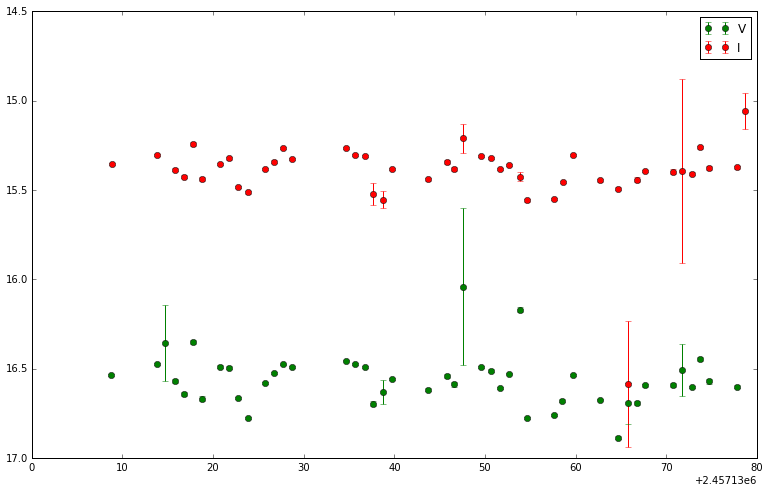

In [26]:
#lets make a plot of our results now to see the light curve
#you should ignore points with large errorbars, these are likely due to nights with bad weather
fig=plt.figure(figsize=(13,8))

ax=fig.add_subplot(111)
ax.errorbar(photVTableMC.juliandate, photVTableMC.Cal, yerr=photVTableMC.merr1, fmt='go', label='V')
ax.errorbar(photITableMC.juliandate, photITableMC.Cal, yerr=photITableMC.merr1, fmt='ro', label='I')

ax.invert_yaxis()
plt.legend()
plt.show()
